[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yeticheese/NMA_Impact_Scholars_Steinmetz/blob/master/notebooks/EDA_PSTH_Analysis.ipynb)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, requests
import sys

from scipy.signal import find_peaks
import scipy
from scipy.stats import median_abs_deviation
import scipy.stats as stats
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# Local
root = r"C:\Python Work Directory\NMA_Impact_Scholars_Steinmetz"
file_directory = 'path/to/directory'
sys.path.append(root)


In [3]:
# Step 2: Extract and Visualize Data from alldat.
# Load Data
fnames = []
for j in range(1,4,1):
  fnames.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fnames[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fnames[j], "wb") as fid:
          fid.write(r.content)

# Function to load data from npz files
def load_data(filenames):
    alldat = np.array([])
    for filename in filenames:
        data = np.load(filename, allow_pickle=True)['dat']
        alldat = np.hstack((alldat, data))
    return alldat

# Download data if not already present
# download_data(urls, filenames)

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

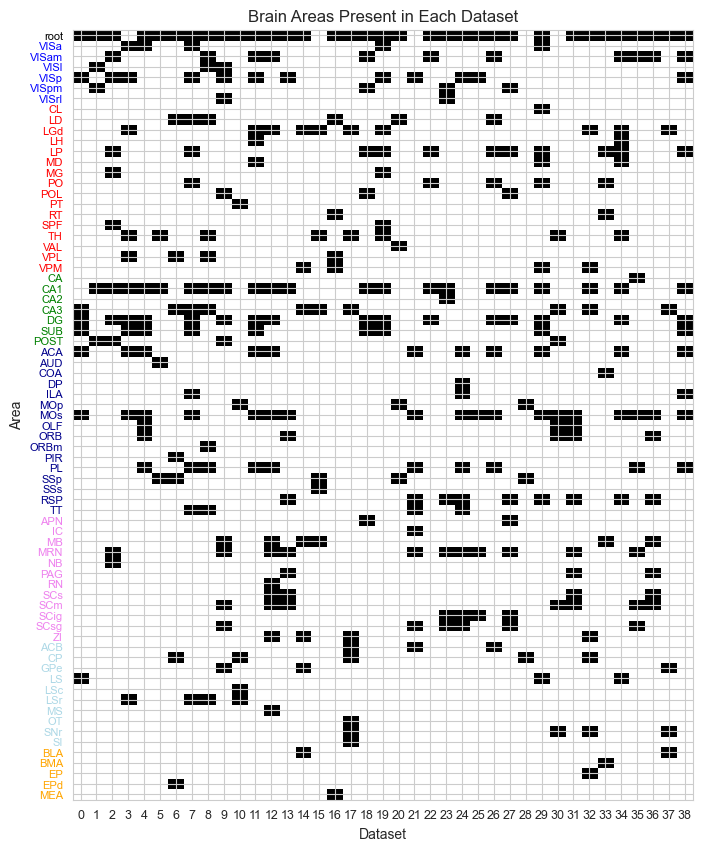

In [4]:
# Function to plot brain areas present in each dataset
def plot_brain_areas(data):
    # Brain Region Information
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    region_colors = ['blue', 'red', 'green', 'darkblue', 'violet', 'lightblue', 'orange', 'gray']
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"],  # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"],  # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"],  # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"],  # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"],  # basal ganglia
                    ["BLA", "BMA", "EP", "EPd", "MEA"]  # cortical subplate
                    ]

    # Assign Each Area an Index
    area_to_index = dict(root=0)
    counter = 1
    for group in brain_groups:
        for area in group:
            area_to_index[area] = counter
            counter += 1

    # Determine Areas in Each Dataset
    areas_by_dataset = np.zeros((counter, len(data)), dtype=bool)
    for j, d in enumerate(data):
        for area in np.unique(d['brain_area']):
            i = area_to_index.get(area, -1)
            if i != -1:
                areas_by_dataset[i, j] = True

    # Visualize the Presence of Neurons in Different Regions Across Datasets
    plt.figure(figsize=(8, 10))
    plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

    # Label the Axes
    plt.xlabel("Dataset")
    plt.ylabel("Area")

    # Add Tick Labels
    yticklabels = ["root"]
    for group in brain_groups:
        yticklabels.extend(group)
    plt.yticks(np.arange(counter), yticklabels, fontsize=8)
    plt.xticks(np.arange(len(data)), fontsize=9)
 
    ytickobjs = plt.gca().get_yticklabels()
    ytickobjs[0].set_color("black")
    counter = 1
    for group, color in zip(brain_groups, region_colors):
        for area in group:
            ytickobjs[counter].set_color(color)
            counter += 1

    plt.title("Brain Areas Present in Each Dataset")
    plt.grid(True)
    plt.show()

# Plot brain areas present in each dataset
alldat = load_data(fnames)
plot_brain_areas(alldat)

In [5]:
print(alldat[1].keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [6]:
print(alldat[1]['spks'].shape)
print(alldat[1]['wheel'].shape)
print(alldat[1]['response_time'].shape)
print(alldat[1]['stim_onset'])
print(alldat[1]['feedback_time'].shape)
print(alldat[1]['feedback_type'].shape)
print(alldat[1]['pupil'].shape)
print(alldat[1]['prev_reward'].shape)
print(alldat[1]['reaction_time'].shape)
print(alldat[1]['face'].shape)
print(alldat[1]['licks'].shape)
print(alldat[1]['wheel'].shape)
print(alldat[1]['spks_passive'].shape)
print(alldat[1]['cellid_orig'][:100])

(1070, 251, 250)
(1, 251, 250)
(251, 1)
0.5
(251, 1)
(251,)
(3, 251, 250)
(251, 1)
(251, 2)
(1, 251, 250)
(1, 251, 250)
(1, 251, 250)
(1070, 150, 250)
[ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True False  True  True  True  True
  True  True  True  True]


In [7]:
print(alldat[1]['response'] == alldat[1]['reaction_time'][:,1])

[ True  True False  True  True  True  True  True  True False  True  True
  True  True False  True False  True False False  True  True  True  True
  True  True  True False  True  True  True  True  True  True False  True
 False False  True  True False  True False  True  True  True False  True
  True False  True False False  True  True  True  True False  True  True
  True  True False  True  True  True  True  True False  True  True False
  True False  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True False  True  True  True  True  True  True  True
  True  True False  True  True  True  True False False  True  True  True
  True  True  True  True  True False  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  T

In [8]:
print(alldat[1]['reaction_time'][:,0])

[ 230. 1460.  250.  180.  450.   inf  110.  160.  390.  560.  170.   90.
  200.  180.  170.  160.  230.  340.  200.  440.   inf  100.  200.  160.
  830.  150.  130.  320.  160.  190.  170.   80.  170.   inf 1240.  210.
  190.  360.  340.   inf  260.  190.  280.  100.  160.  210.   40.   inf
   inf  150.  180.  920.  310.  160.  170.  180.  160.  110.  390.   inf
  180.   inf  260.  570.   50.  160.   70.  210.  220.   inf  190.   inf
  180.  540.  160. 1020.  180. 1050.  510.  160.  220.  230.  180.  140.
  170.  190.  210.  230.   inf 1630.  870. 1280. 1060.  210.  190.  340.
 1260. 1200.   inf  220.  180.   inf   inf  500.  210.  570.  140.  860.
   inf  180.  240.  180.  930.  220.  170.  260.  240.  310.   inf  210.
  410.  690.  200.  580. 1230.   inf   inf  950.   20.  170.  220. 1060.
   inf   inf  600.   inf 1010.   70.  550.   inf 1380. 1080.   inf  540.
 1200.   inf  710.   inf   inf   inf   inf   inf   inf   inf   inf   inf
   inf   inf   inf   inf  570.  860. 1940. 1360.  7

In [9]:
brain_groups = {'visual_cortex':["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], 
                'thalamus': ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], 
                'hippocampal': ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"],  
                'non_visual_cortex': ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP", "TT"], 
                'midbrain': ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], 
                'basal_ganglia': ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], 
                'cortical_subplate': ["BLA", "BMA", "EP", "EPd", "MEA"]}

In [10]:
brain_areas = []
for vals in brain_groups.values():
    brain_areas += vals
print(brain_areas)

['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl', 'CL', 'LD', 'LGd', 'LH', 'LP', 'MD', 'MG', 'PO', 'POL', 'PT', 'RT', 'SPF', 'TH', 'VAL', 'VPL', 'VPM', 'CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB', 'POST', 'ACA', 'AUD', 'COA', 'DP', 'ILA', 'MOp', 'MOs', 'OLF', 'ORB', 'ORBm', 'PIR', 'PL', 'SSp', 'SSs', 'RSP', 'TT', 'APN', 'IC', 'MB', 'MRN', 'NB', 'PAG', 'RN', 'SCs', 'SCm', 'SCig', 'SCsg', 'ZI', 'ACB', 'CP', 'GPe', 'LS', 'LSc', 'LSr', 'MS', 'OT', 'SNr', 'SI', 'BLA', 'BMA', 'EP', 'EPd', 'MEA']


In [11]:
def plot_neuron_spikes(spike_data, ax):

                    
    num_neurons = len(spike_data)

    neurons_round = rounded = int(np.ceil(num_neurons / 1000) * 1000)
    
    # Plot spikes using eventplot
    ax.eventplot(spike_data, lineoffsets=range(num_neurons),
                 linelengths=1, colors='black',linestyles='solid')
    
    # Set y-axis ticks and labels
    ax.set_yticks([0, neurons_round//2, neurons_round])
    # ax.set_yticklabels(['1', f'{num_neurons//2}', f'{num_neurons}'])
    ax.set_xticks(np.arange(-500, 2000, 500))
    # ax.set_yticklabels(['-500','0','500','1000','1500','2000'])
    # Set labels and title
    ax.set_ylabel('Neuron')

In [12]:
def trial_subroutines(key, value):
    match key:
        case 'response':
            return value
        case 'response_time':
            return np.squeeze(value)
        case 'contrast_left':
            return value
        case 'contrast_right':
            return value
        case 'feedback_time':
            return np.squeeze(value)
        case 'feedback_type':
            return value
        case 'gocue':
            return np.squeeze(value)
        case 'prev_reward':
            return np.squeeze(value)
        case _:
            return None

In [13]:
def neuron_subroutines(key, value):
    match key:
        case 'brain_area':
            return value
        # case 'ccf':
        #     return value
        case _:
            return None


In [14]:
def dat_subroutines(dat):
    neuron_data = {}
    trial_data = {}
    for key, value in dat.items():
        neuron_result = neuron_subroutines(key, value)
        trial_result = trial_subroutines(key, value)





        # Only add to dictionary if the result is not
        if neuron_result is not None:
            neuron_data[key] = neuron_result
        if trial_result is not None:
            trial_data[key] = trial_result


    # Create DataFrames from the processed data
    neuron_df = pd.DataFrame(neuron_data)
    trial_df = pd.DataFrame(trial_data)


    # Add common fields
    for df in [neuron_df, trial_df]:
        if 'mouse_name' in dat:
            df['mouse_name'] = dat['mouse_name']
        if 'date_exp' in dat:
            df['date_exp'] = pd.to_datetime(dat['date_exp'])

    neuron_df[[*dat['ccf_axes']]] = dat['ccf']
    trial_df[['reaction_time','reaction_type']] = dat['reaction_time']

    trial_df['pupil_area'] = list(dat['pupil'][0,:,:])
    trial_df['pupil_x'] = list(dat['pupil'][1,:,:])
    trial_df['pupil_y'] = list(dat['pupil'][2,:,:])
    trial_df['face'] = list(np.squeeze(dat['face']))
    trial_df['licks'] = list(np.squeeze(dat['licks']))
    trial_df['wheel'] = list(np.squeeze(dat['wheel']))
    trial_df['average_pupil_speed'] = list(np.sqrt(((np.diff(dat['pupil'][1,:,:], axis=1)/0.01)**2)+((np.diff(dat['pupil'][2,:,:], axis=1)/0.01)**2)))

    # Add index columns
    neuron_df['neuron_id'] = range(len(neuron_df))
    trial_df['trial_id'] = range(len(trial_df))

    # Create cross join between neurons and trials
    # First, add a temporary key for merging
    neuron_df['_merge_key'] = 1
    trial_df['_merge_key'] = 1

    # Perform the merge
    merged_df = pd.merge(
        neuron_df,
        trial_df,
        on='_merge_key',
        suffixes=('_neuron', '_trial')
    ).drop('_merge_key', axis=1)

    # Deduplicate common columns (mouse_name and date_exp)
    for col in merged_df.columns:
        if col.endswith('_neuron') and col.replace('_neuron', '_trial') in merged_df.columns:
            base_col = col.replace('_neuron', '')
            if (merged_df[col] == merged_df[col.replace('_neuron', '_trial')]).all():
                merged_df[base_col] = merged_df[col]
                merged_df = merged_df.drop([col, col.replace('_neuron', '_trial')], axis=1)

    # Reset the index
    merged_df = merged_df.reset_index(drop=True)
    spikes = dat['spks'].reshape(-1,250)



    merged_df['spks'] = list(spikes)

    return merged_df


In [15]:
concat_df = pd.DataFrame()
dfs=[]
for dat in alldat:
    dfs.append(dat_subroutines(dat))
    
concat_df = pd.concat(dfs)
print(concat_df.shape)

dfs_select = []
for area in concat_df.brain_area.unique():
    selected_df = concat_df.query(f'brain_area == "{area}"')
    print(selected_df.shape)
    # Create a mapping dictionary from old to new IDs
    unique_neurons = selected_df.neuron_id.unique()
    new_neuron_ids = np.arange(len(unique_neurons))
    id_mapping = dict(zip(unique_neurons, new_neuron_ids))
    
    # Map old IDs to new IDs
    selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
    dfs_select.append(selected_df)
        
concat_df = pd.concat(dfs_select)
print(concat_df.shape)


(8787226, 26)
(227065, 26)
(423791, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(104576, 26)
(1081747, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(312663, 26)
(129950, 26)
(179482, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(204202, 26)
(349261, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(140922, 26)
(129982, 26)
(84661, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(253508, 26)
(68366, 26)
(12350, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(156624, 26)
(267980, 26)
(9804, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(246266, 26)
(346383, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(82996, 26)
(82112, 26)
(122709, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(65500, 26)
(192481, 26)
(263214, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(71340, 26)
(75342, 26)
(71382, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(275519, 26)
(13104, 26)
(16884, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(121021, 26)
(54274, 26)
(145302, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(45384, 26)
(264089, 26)
(91117, 26)
(44871, 26)
(79810, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(102842, 26)
(88842, 26)
(196498, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(24624, 26)
(15390, 26)
(101081, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(7986, 26)
(90424, 26)
(41211, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(17400, 26)
(6900, 26)
(181490, 26)
(29797, 26)
(90143, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(99109, 26)
(33600, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(48040, 26)
(9184, 26)
(112598, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(8216, 26)
(15168, 26)
(80313, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(54499, 26)
(10292, 26)
(25752, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(21505, 26)
(160038, 26)
(10179, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(4576, 26)
(17381, 26)
(30784, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of

(93536, 26)
(49794, 26)


C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)
C:\Users\abumohammed\AppData\Local\Temp\ipykernel_19412\526780340.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['neuron_id'] = selected_df['neuron_id'].map(id_mapping)


(8787226, 26)


In [16]:
concat_df.head()

,brain_area,ap,dv,lr,neuron_id,response,response_time,contrast_right,contrast_left,feedback_time,...,pupil_x,pupil_y,face,licks,wheel,average_pupil_speed,trial_id,mouse_name,date_exp,spks
0,ACA,4090.0,2445.4,5012.4,0,1.0,1.150204,0.0,1.0,1.186819,...,"[0.8128560079370007, 0.7781619288408106, 0.812...","[0.6642474546970106, 0.6127515969655603, 0.632...","[1.1457347728534013, 1.1457347728534013, 1.145...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[6.209269270880815, 3.9618719802556384, 15.514...",0,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,ACA,4090.0,2445.4,5012.4,0,-1.0,1.399503,0.5,0.0,1.437623,...,"[0.9481738640399882, 0.95962931787718, 0.95623...","[1.2327374650971357, 1.1461163994720454, 1.075...","[2.017052985665972, 2.017052985665972, 2.01705...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 1.0...","[8.737526213203733, 7.03354040999631, 13.82820...",1,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,ACA,4090.0,2445.4,5012.4,0,1.0,0.949291,0.5,1.0,0.986016,...,"[0.3880897000778937, 0.38561680094358525, 0.32...","[-0.5459380913456507, -0.5497186468959199, -0....","[1.4639606285105065, 1.4639606285105065, 1.126...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0...","[0.4517502672620578, 5.709125370596854, 3.9920...",2,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ACA,4090.0,2445.4,5012.4,0,0.0,2.266802,0.0,0.0,2.296436,...,"[0.5486736122593511, 0.5706127730128381, 0.607...","[0.31674671014607647, 0.3865733154225462, 0.58...","[1.7438533505033715, 1.7438533505033715, 1.757...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[7.319208686055655, 20.082483878493004, 2.8472...",3,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,ACA,4090.0,2445.4,5012.4,0,1.0,0.816776,1.0,0.5,0.827613,...,"[0.16297604976200375, 0.11803934958464492, 0.1...","[-0.001497431166922816, 0.11724225390846806, 0...","[1.3459189153222113, 0.717377215716495, 0.7173...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0,...","[12.695833897240796, 3.510899717497929, 16.199...",4,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
# load_df = pd.read_csv(os.path.join(save_dir,'steinmetz_neuron_spikes.csv'))

In [18]:
# Convert unordered pairs to ordered pairs
concat_df['contrast_pair'] = concat_df.apply(lambda row: tuple(sorted([row['contrast_left'], row['contrast_right']], reverse=True)), axis=1)



sort_df = concat_df.sort_values('contrast_pair',ascending=True)
unique_pairs = sort_df['contrast_pair'].unique()

# Count the unique pairs
num_unique_combinations = len(unique_pairs)

# Output results
print("Unique combinations:", unique_pairs)
print("Number of unique combinations:", num_unique_combinations)
diffs = np.squeeze(np.array([np.diff(x) for x in unique_pairs]) != 0)
print(diffs)


Unique combinations: [(0.0, 0.0) (0.25, 0.0) (0.25, 0.25) (0.5, 0.0) (0.5, 0.25) (0.5, 0.5)
 (1.0, 0.0) (1.0, 0.25) (1.0, 0.5) (1.0, 1.0)]
Number of unique combinations: 10
[False  True False  True  True False  True  True  True False]


In [19]:
concat_df['trial_outcome'] = concat_df.apply(lambda row: 'left_reward' if (row['contrast_left'] > row['contrast_right']) & (row['response'] == 1) & (row['feedback_type'] == 1)
else 'right_reward' if (row['contrast_right'] > row['contrast_left']) & (row['response'] == -1) & (row['feedback_type'] == 1)
                                             else 'left_penalty' if (row['contrast_left'] > row['contrast_right']) & (row['response'] == -1) & (row['feedback_type'] == -1)
                                             else 'right_penalty'  if (row['contrast_right'] > row['contrast_left']) & (row['response'] == 1) & (row['feedback_type'] == -1)
                                             else 'nogo',
                                             axis=1)

In [20]:
concat_df.head()

,brain_area,ap,dv,lr,neuron_id,response,response_time,contrast_right,contrast_left,feedback_time,...,face,licks,wheel,average_pupil_speed,trial_id,mouse_name,date_exp,spks,contrast_pair,trial_outcome
0,ACA,4090.0,2445.4,5012.4,0,1.0,1.150204,0.0,1.0,1.186819,...,"[1.1457347728534013, 1.1457347728534013, 1.145...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[6.209269270880815, 3.9618719802556384, 15.514...",0,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.0)",left_reward
1,ACA,4090.0,2445.4,5012.4,0,-1.0,1.399503,0.5,0.0,1.437623,...,"[2.017052985665972, 2.017052985665972, 2.01705...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 1.0, 1.0...","[8.737526213203733, 7.03354040999631, 13.82820...",1,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0.5, 0.0)",right_reward
2,ACA,4090.0,2445.4,5012.4,0,1.0,0.949291,0.5,1.0,0.986016,...,"[1.4639606285105065, 1.4639606285105065, 1.126...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0...","[0.4517502672620578, 5.709125370596854, 3.9920...",2,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.5)",left_reward
3,ACA,4090.0,2445.4,5012.4,0,0.0,2.266802,0.0,0.0,2.296436,...,"[1.7438533505033715, 1.7438533505033715, 1.757...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[7.319208686055655, 20.082483878493004, 2.8472...",3,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0.0, 0.0)",nogo
4,ACA,4090.0,2445.4,5012.4,0,1.0,0.816776,1.0,0.5,0.827613,...,"[1.3459189153222113, 0.717377215716495, 0.7173...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0,...","[12.695833897240796, 3.510899717497929, 16.199...",4,Cori,2016-12-14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1.0, 0.5)",right_penalty


In [21]:
print(unique_pairs[np.squeeze(diffs)])

[(0.25, 0.0) (0.5, 0.0) (0.5, 0.25) (1.0, 0.0) (1.0, 0.25) (1.0, 0.5)]


In [22]:
# Define readable colors from matplotlib's named colors
color_list = [
    'red', 'blue', 'red', 'green', 'blue',
    'green']

# Create a dictionary mapping unique combinations to colors
combination_to_color = {combo: color for combo, color in zip(unique_pairs[np.squeeze(diffs)], color_list)}

In [23]:
print(combination_to_color)

{(0.25, 0.0): 'red', (0.5, 0.0): 'blue', (0.5, 0.25): 'red', (1.0, 0.0): 'green', (1.0, 0.25): 'blue', (1.0, 0.5): 'green'}


In [24]:
def str_to_array(string:str) -> np.ndarray:
    array = np.array(string.strip('[]').split()).astype(np.float64)
    return array


In [25]:
def binarize_spikes(spike_data, threshold=0):
    """
    Binarize spike data by converting to binary events.

    Parameters:
    spike_data (np.ndarray): 2D array of spike data
    threshold (float): Threshold for spike detection

    Returns:
    list of lists: Binary spike times for each trial
    """
    binary_spikes = []
    time_points = np.arange(-495, 2005, 10)

    for trial in spike_data:
        # Find indices where spikes occur (above threshold)
        spike_indices = np.where(trial > threshold)[0]

        # Convert indices to actual time points
        spike_times = time_points[spike_indices]
        binary_spikes.append(spike_times)

    return binary_spikes

def plot_decision_trials_eventplot(data_df: pd.DataFrame, area: str, color_dict):
    """
    Create a 2x2 grid of event plots with their PSTHs, sorted by contrast difference
    using matplotlib

    Parameters:
    data_df: DataFrame containing trial data
    area: str, the brain area to filter by
    neuron_no: neuron identifier

    Returns:
    matplotlib Figure object
    """
    # Define parameters and filter conditions
    titles_list = ['Left Contrast Reward', 'Left Contrast Penalty', 'Right Contrast Reward', 'Right Contrast Penalty']
    right_response = -1
    left_response = 1
    correct_feedback = 1
    incorrect_feedback = -1

    # Color palette
    stimulus_color = 'red'
    colors = color_dict

    left_correct_reward = data_df.query(f'(contrast_left > contrast_right) & (response == @left_response) & (feedback_type == @correct_feedback)')
    left_correct_penalty = data_df.query('(contrast_left > contrast_right) & (response == @right_response) & (feedback_type == @incorrect_feedback)')
    right_correct_reward = data_df.query('(contrast_left < contrast_right) & (response == @right_response) & (feedback_type == @correct_feedback)')
    right_correct_penalty = data_df.query('(contrast_left < contrast_right) & (response == @left_response) & (feedback_type == @incorrect_feedback)')


    df_list = [left_correct_reward, left_correct_penalty, right_correct_reward, right_correct_penalty]
    df_filtered = [x.query(f'brain_area == "{area}"') for x in df_list]

    # Sort each DataFrame by contrast difference and store contrast differences
    sorted_df_filtered = []
    contrasts_list = []
    for i, df in enumerate(df_filtered):
        sorted_df = df.sort_values('contrast_pair', ascending=True)
        sorted_df_filtered.append(sorted_df)
        contrasts_list.append(sorted_df['contrast_pair'].values)

    spikes_list = [np.array(df.spks.to_list()) for df in sorted_df_filtered]

    avg_speed = [np.array(df.average_pupil_speed.to_list()) for df in sorted_df_filtered]

    wheel_speed = [np.array(df.wheel.to_list()) for df in sorted_df_filtered]

    pupil_area = [np.array(df.pupil_area.to_list()) for df in sorted_df_filtered]



    # Time points for x-axis
    time_points = np.arange(-495, 2005, 10)

    # Create figure
    fig = plt.figure(figsize=(15, 42))  # Increased height to accommodate title
    gs = fig.add_gridspec(10, 2, height_ratios=[0.7, 0.5, 0.5, 0.5, 0.5, 0.7, 0.5, 0.5, 0.5, 0.5])
    axs = []
    for i in range(10):
        for j in range(2):
            axs.append(fig.add_subplot(gs[i, j]))
    axs = np.array(axs).reshape(10, 2)

    # Add figure title with proper spacing
    fig.suptitle(f'{area} Spike Train Event Plots with PSTH', 
                fontsize=14, 
                y=0.98)  # Adjusted y position for better spacing

    psth_ylims = []
    wheel_ylims = []
    speed_ylims = []
    pupil_area_ylims = []
    df_contrast_pair = left_correct_reward.contrast_pair.unique()
    for idx,(spike_data, pupil_speed, pupil_size, wheel, df) in enumerate(zip(spikes_list, avg_speed, pupil_area, wheel_speed, sorted_df_filtered)):

        contrast_pair_array = df.contrast_pair.to_numpy()

        changes = np.where(contrast_pair_array[:-1] != contrast_pair_array[1:])[0].astype(int)  + 1


        

        spike_colors = []
        color_map ={}

        for id, c_val  in enumerate(df.contrast_pair.unique()):
            color_map[c_val] = colors[c_val]
            if id == 0:
                spike_colors = spike_colors + [colors[c_val] for _ in range(changes[id])]

            elif id == len(df.contrast_pair.unique()) - 1:
                spike_colors = spike_colors + [colors[c_val] for _ in range(len(contrast_pair_array) - changes[id-1])]

            else:
                spike_colors = spike_colors + [colors[c_val] for _ in range(changes[id] - changes[id-1])]


        if idx < 2:
            raster_ax = axs[idx*5, 0]
            psth_ax = axs[(idx*5)+1, 0]
            wheel_ax = axs[(idx*5)+2, 0]
            speed_ax = axs[(idx*5)+3, 0]
            pupil_area_ax = axs[(idx*5)+4, 0]

            raster_ax.set_ylabel('Trials')
            psth_ax.set_ylabel('Firing rate (Hz)')
            wheel_ax.set_ylabel('Speed')
            speed_ax.set_ylabel('Speed (m/s) #Placeholder Dimensions') #Placeholder dimensions
        elif idx >= 2:
            raster_ax = axs[(idx-2)*5, 1]
            psth_ax = axs[((idx-2)*5)+1, 1]
            wheel_ax = axs[((idx-2)*5)+2, 1]
            speed_ax = axs[((idx-2)*5)+3, 1]
            pupil_area_ax = axs[((idx-2)*5)+4, 1]

        # Remove grid lines
        raster_ax.grid(False)
        psth_ax.grid(False)
        wheel_ax.grid(False)
        speed_ax.grid(False)
        pupil_area_ax.grid(False)

        # If insufficient data
        if spike_data.shape[0] < 10:
            raster_ax.text(0.5, 0.5, f"Not enough trial data",
                           horizontalalignment='center', verticalalignment='center')
            psth_ax.text(0.5, 0.5, f"Not enough trial data",
                         horizontalalignment='center', verticalalignment='center')
            continue

        # Binarize spike data
        binary_spikes = binarize_spikes(spike_data)

        # Eventplot (raster equivalent)
        raster_ax.eventplot(binary_spikes, color=spike_colors, linewidths=1)

        # Stimulus onset line
        raster_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2, label ='stimulus onset')
        psth_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
        wheel_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
        speed_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)
        pupil_area_ax.axvline(x=0, color=stimulus_color, linestyle='--', linewidth=2)

        psth_lim = []
        wheel_lim = []
        speed_lim = []
        pupil_area_lim = []
        for id,(change, (k_, v_)) in enumerate(zip(changes, color_map.items())):
            contrast_key = list(color_map.keys())[-1]
            if len(changes) == 1:
                    # PSTH
                    psth = np.mean(spike_data[:change], axis=0) / (10 / 1000)
                    psth_ax.plot(time_points, psth, color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    psth_lim.append(np.max(psth))
                    psth = np.mean(spike_data[change:], axis=0) / (10 / 1000)
                    psth_ax.plot(time_points, psth, color=list(color_map.values())[1], linewidth=2, label= f'contrast_pair {str(list(color_map.keys())[1])}')
                    psth_lim.append(np.max(psth))

                    # Wheel
                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[:change], axis=0)), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[:change]))))
                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[change:], axis=0)), color=list(color_map.values())[1], linewidth=2, label= f'contrast_pair {str(list(color_map.keys())[1])}')
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[change:]))))

                    # Average Pupil Speed
                    speed_ax.plot(time_points[1:], np.median(pupil_speed[:change], axis=0), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    speed_lim.append(np.max(np.median(pupil_speed[:change])))
                    speed_ax.plot(time_points[1:], np.median(pupil_speed[change:], axis=0), color=list(color_map.values())[1], linewidth=2, label= f'contrast_pair {str(list(color_map.keys())[1])}')
                    speed_lim.append(np.max(np.median(pupil_speed[:change])))

                    # Average Pupil Area Change
                    pupil_area_ax.plot(time_points, np.median(pupil_size[:change], axis=0), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    pupil_area_lim.append(np.max(np.median(pupil_size[:change])))
                    pupil_area_ax.plot(time_points, np.median(pupil_size[change:], axis=0), color=list(color_map.values())[1], linewidth=2, label= f'contrast_pair {str(list(color_map.keys())[1])}')
                    pupil_area_lim.append(np.max(np.median(pupil_size[change:])))

            else:
                if id == 0:
                    # PSTH
                    psth = np.mean(spike_data[:change], axis=0) / (10 / 1000)
                    psth_ax.plot(time_points, psth, color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')

                    psth_lim.append(np.max(psth))

                    # Wheel
                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[:change], axis=0)), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[:change]))))

                    # Average Pupil Speed
                    speed_ax.plot(time_points[1:], np.median(pupil_speed[:change], axis=0), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    speed_lim.append(np.max(np.median(pupil_speed[:change])))

                    # Average Pupil Area Change
                    pupil_area_ax.plot(time_points, np.median(pupil_size[:change], axis=0), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    pupil_area_lim.append(np.max(np.median(pupil_size[:change])))

                elif id == len(changes)-1:
                    psth_pre = np.mean(spike_data[changes[id-1]:change], axis=0) / (10 / 1000)
                    psth =np.mean(spike_data[change:], axis=0) / (10 / 1000)
                    # PSTH
                    psth_ax.plot(time_points, psth_pre, color=v_, linewidth=2, label=f'contrast_pair {str(k_)}')
                    psth_ax.plot(time_points, psth, color=colors[contrast_key], linewidth=2, label= f'contrast_pair {str(contrast_key)}')
                    psth_lim.append(np.max(psth_pre))
                    psth_lim.append(np.max(psth))

                    # Wheel
                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[changes[id-1]:change], axis=0)), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[change:], axis=0)), color=colors[contrast_key], linewidth=2, label= f'contrast_pair {contrast_key}')
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[changes[id-1]:change], axis=0))))
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[change:],axis=0))))

                    # Average Pupil Speed
                    speed_ax.plot(time_points[1:], np.median(pupil_speed[changes[id-1]:change], axis=0), color=v_, linewidth=2, label = f'contrast_pair {str(k_)}')
                    speed_ax.plot(time_points[1:], np.median(pupil_speed[change:], axis=0), color=colors[contrast_key], linewidth=2, label= f'contrast_pair {contrast_key}')
                    speed_lim.append(np.max(np.median(pupil_speed[changes[id-1]:change],axis=0)))
                    speed_lim.append(np.max(np.median(pupil_speed[change:],axis=0)))

                    # Average Pupil Area Change
                    pupil_area_ax.plot(time_points, np.median(pupil_size[changes[id-1]:change], axis=0), color=v_, linewidth=2, label = f'contrast_pair {str(k_)}')
                    pupil_area_ax.plot(time_points, np.median(pupil_size[change:], axis=0), color=colors[contrast_key], linewidth=2, label= f'contrast_pair {contrast_key}')
                    pupil_area_lim.append(np.max(np.median(pupil_size[changes[id-1]:change],axis=0)))
                    pupil_area_lim.append(np.max(np.median(pupil_size[change:],axis=0)))

                else:
                    psth = np.mean(spike_data[changes[id-1]:change], axis=0) / (10 / 1000)
                    psth_ax.plot(time_points, np.mean(spike_data[changes[id-1]:change], axis=0) / (10 / 1000), color=v_, linewidth=2, label=f'contrast_pair {str(k_)}')
                    psth_lim.append(np.max(psth))

                    wheel_ax.plot(time_points, np.abs(np.mean(wheel[changes[id-1]:change], axis=0)), color=v_, linewidth=2, label= f'contrast_pair {str(k_)}')
                    wheel_lim.append(np.max(np.abs(np.mean(wheel[changes[id-1]:change],axis=0))))

                    speed_ax.plot(time_points[1:], np.median(pupil_speed[changes[id-1]:change], axis=0), color=v_, linewidth=2, label = f'contrast_pair {str(k_)}')
                    speed_lim.append(np.max(np.median(pupil_speed[changes[id-1]:change],axis=0)))

                    pupil_area_ax.plot(time_points, np.median(pupil_size[changes[id-1]:change], axis=0), color=v_, linewidth=2, label = f'contrast_pair {str(k_)}')
                    pupil_area_lim.append(np.max(np.median(pupil_size[changes[id-1]:change],axis=0)))

        psth_ylims.append(np.max(np.array(psth_lim)))
        wheel_ylims.append(np.max(np.array(wheel_lim)))
        speed_ylims.append(np.max(np.array(speed_lim)))
        pupil_area_ylims.append(np.max(np.array(pupil_area_lim)))



        # Axis labels and titles
        raster_ax.set_title(titles_list[idx])

        psth_ax.set_title('PSTH')

        wheel_ax.set_title('Average Wheel Speed Across Trials')

        speed_ax.set_title('Average Pupil Speed Across Trials')

        pupil_area_ax.set_title('Pupil Area Change Across Trials')
        pupil_area_ax.set_xlabel('Time (ms)')



        # X-axis limits
        raster_ax.set_xlim(-500, 2000)
        psth_ax.set_xlim(-500, 2000)
        wheel_ax.set_xlim(-500, 2000)
        speed_ax.set_xlim(-500, 2000)
        pupil_area_ax.set_xlim(-500, 2000)

        # Set y-axis limits for
        raster_ax.set_ylim(-1, len(binary_spikes))


        #Legends
        raster_ax.legend(loc='upper right')
        psth_ax.legend(loc='upper right')
        wheel_ax.legend(loc='upper right')
        speed_ax.legend(loc='upper right')
        pupil_area_ax.legend(loc='upper right')
        wheel_ax.legend(loc='upper right')

    axs[1,0].set_ylim(0, np.ceil(max(psth_ylims[::2])))
    axs[6,0].set_ylim(0, np.ceil(max(psth_ylims[1::2])))
    axs[1,1].set_ylim(0, np.ceil(max(psth_ylims[::2])))
    axs[6,1].set_ylim(0, np.ceil(max(psth_ylims[1::2])))


    axs[2,0].set_ylim(0, np.ceil(max(wheel_ylims[::2])))
    axs[7,0].set_ylim(0, np.ceil(max(wheel_ylims[1::2])))
    axs[2,1].set_ylim(0, np.ceil(max(wheel_ylims[::2])))
    axs[7,1].set_ylim(0, np.ceil(max(wheel_ylims[1::2])))

    axs[3,0].set_ylim(0, np.ceil(max(speed_ylims[::2])))
    axs[8,0].set_ylim(0, np.ceil(max(speed_ylims[1::2])))
    axs[3,1].set_ylim(0, np.ceil(max(speed_ylims[::2])))
    axs[8,1].set_ylim(0, np.ceil(max(speed_ylims[1::2])))

    axs[4,0].set_ylim(0, max(pupil_area_ylims[::2])+0.01)
    axs[9,0].set_ylim(0, max(pupil_area_ylims[1::2])+0.01)
    axs[4,1].set_ylim(0, max(pupil_area_ylims[::2])+0.01)
    axs[9,1].set_ylim(0, max(pupil_area_ylims[1::2])+0.01)

    fig.suptitle(f'{area}  Spike Train PSTH, Events contrast pair {df_contrast_pair}', fontsize=12)
    # Replace tight_layout with manual spacing adjustment
    plt.subplots_adjust(
        top=0.96,      # Increased to leave space for title
        bottom=0.05,
        left=0.1,
        right=0.9,
        hspace=0.4,    # Adjusted for better vertical spacing between subplots
        wspace=0.3     # Space between columns
    )

    return fig

In [26]:
no_stim = (0.0,0.0)
no_stim_1 = (1.0,0.0)
no_stim_2 = (0.5,0.0)
no_stim_3 = (0.25,0.0)

stimulus_df = concat_df.query('~(contrast_pair == @no_stim_1) & ~(contrast_pair == @no_stim_2) & ~(contrast_pair == @no_stim_3) & ~(contrast_pair == @no_stim)')

In [27]:
no_stim_df = concat_df.query('(contrast_pair == @no_stim_1) | (contrast_pair == @no_stim_2) | (contrast_pair == @no_stim_3) | (contrast_pair == @no_stim)')
print(no_stim_df.contrast_pair.unique())

[(1.0, 0.0) (0.5, 0.0) (0.0, 0.0) (0.25, 0.0)]


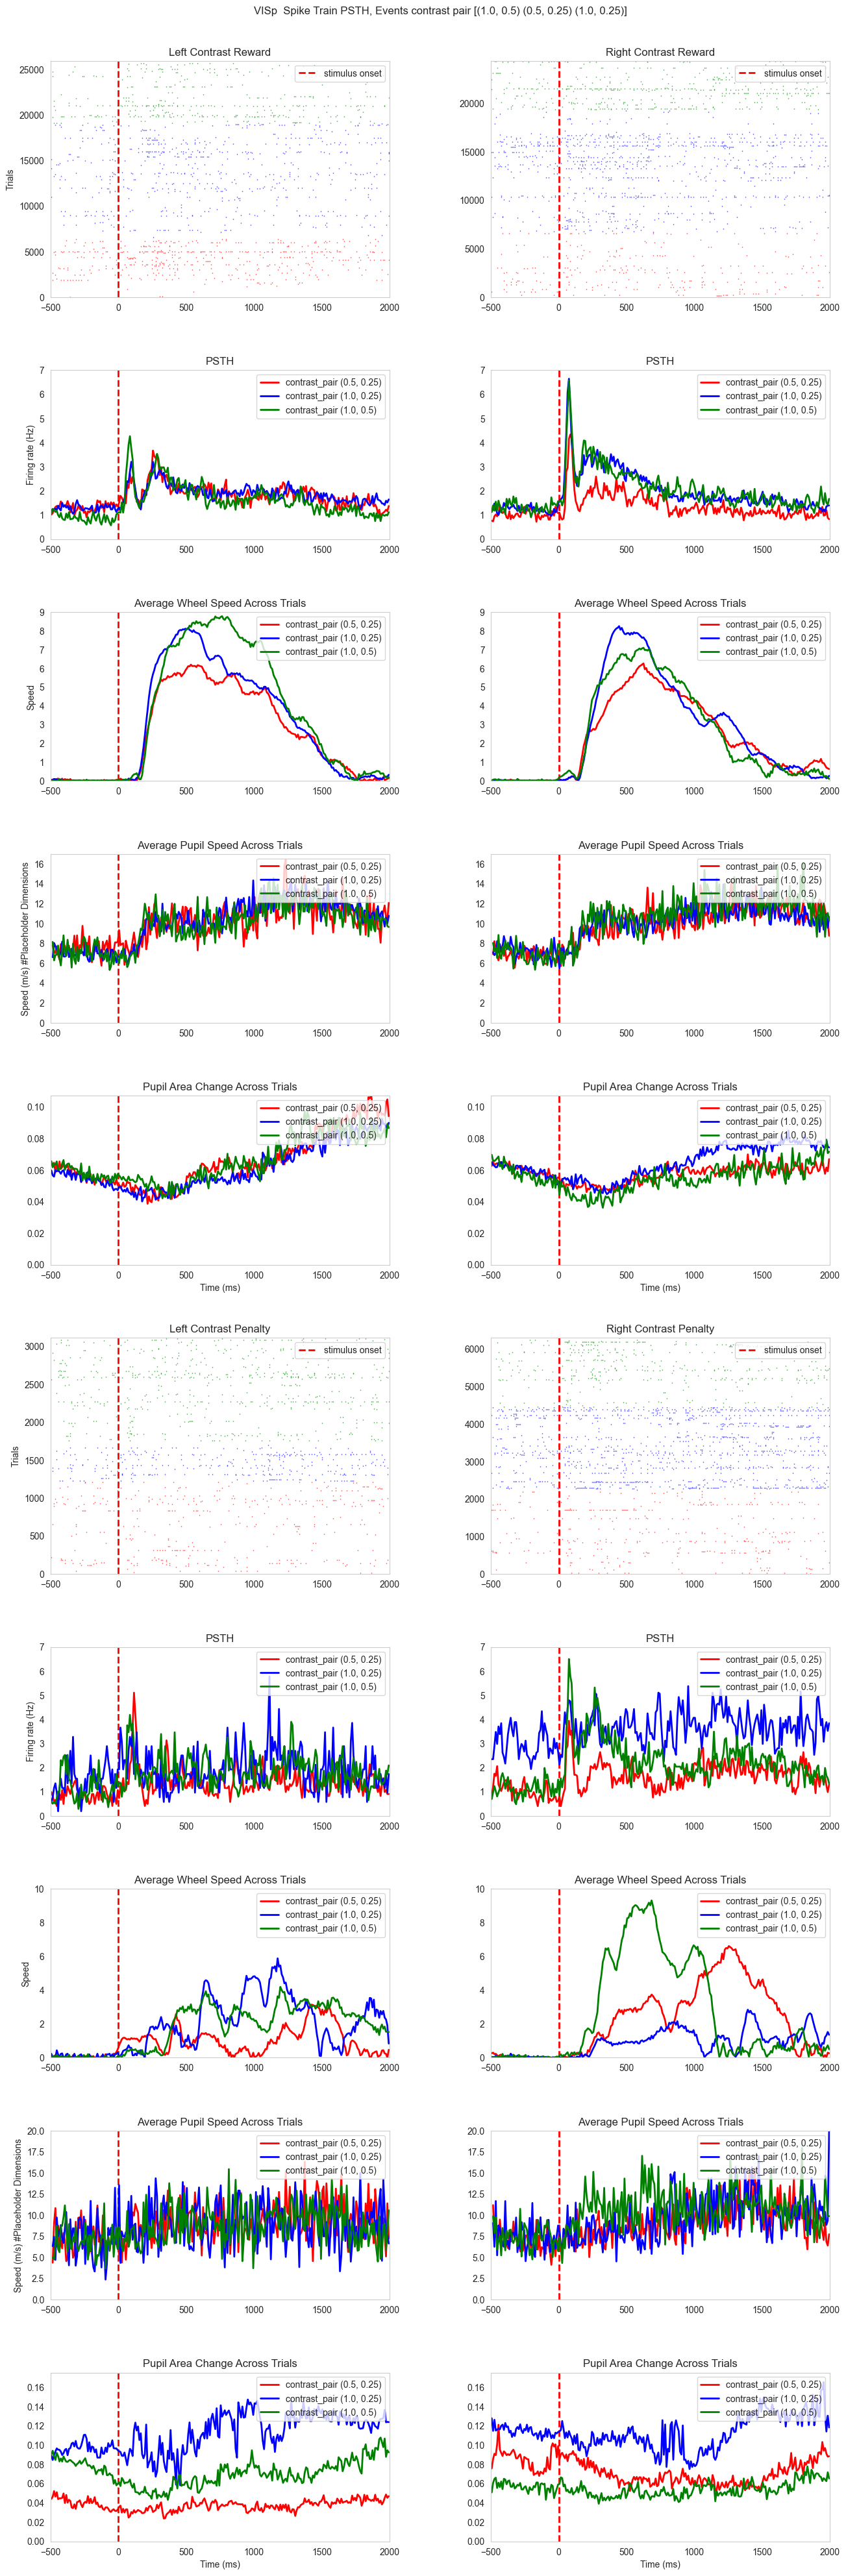

In [28]:
fig = plot_decision_trials_eventplot(stimulus_df,area='VISp', color_dict= combination_to_color)

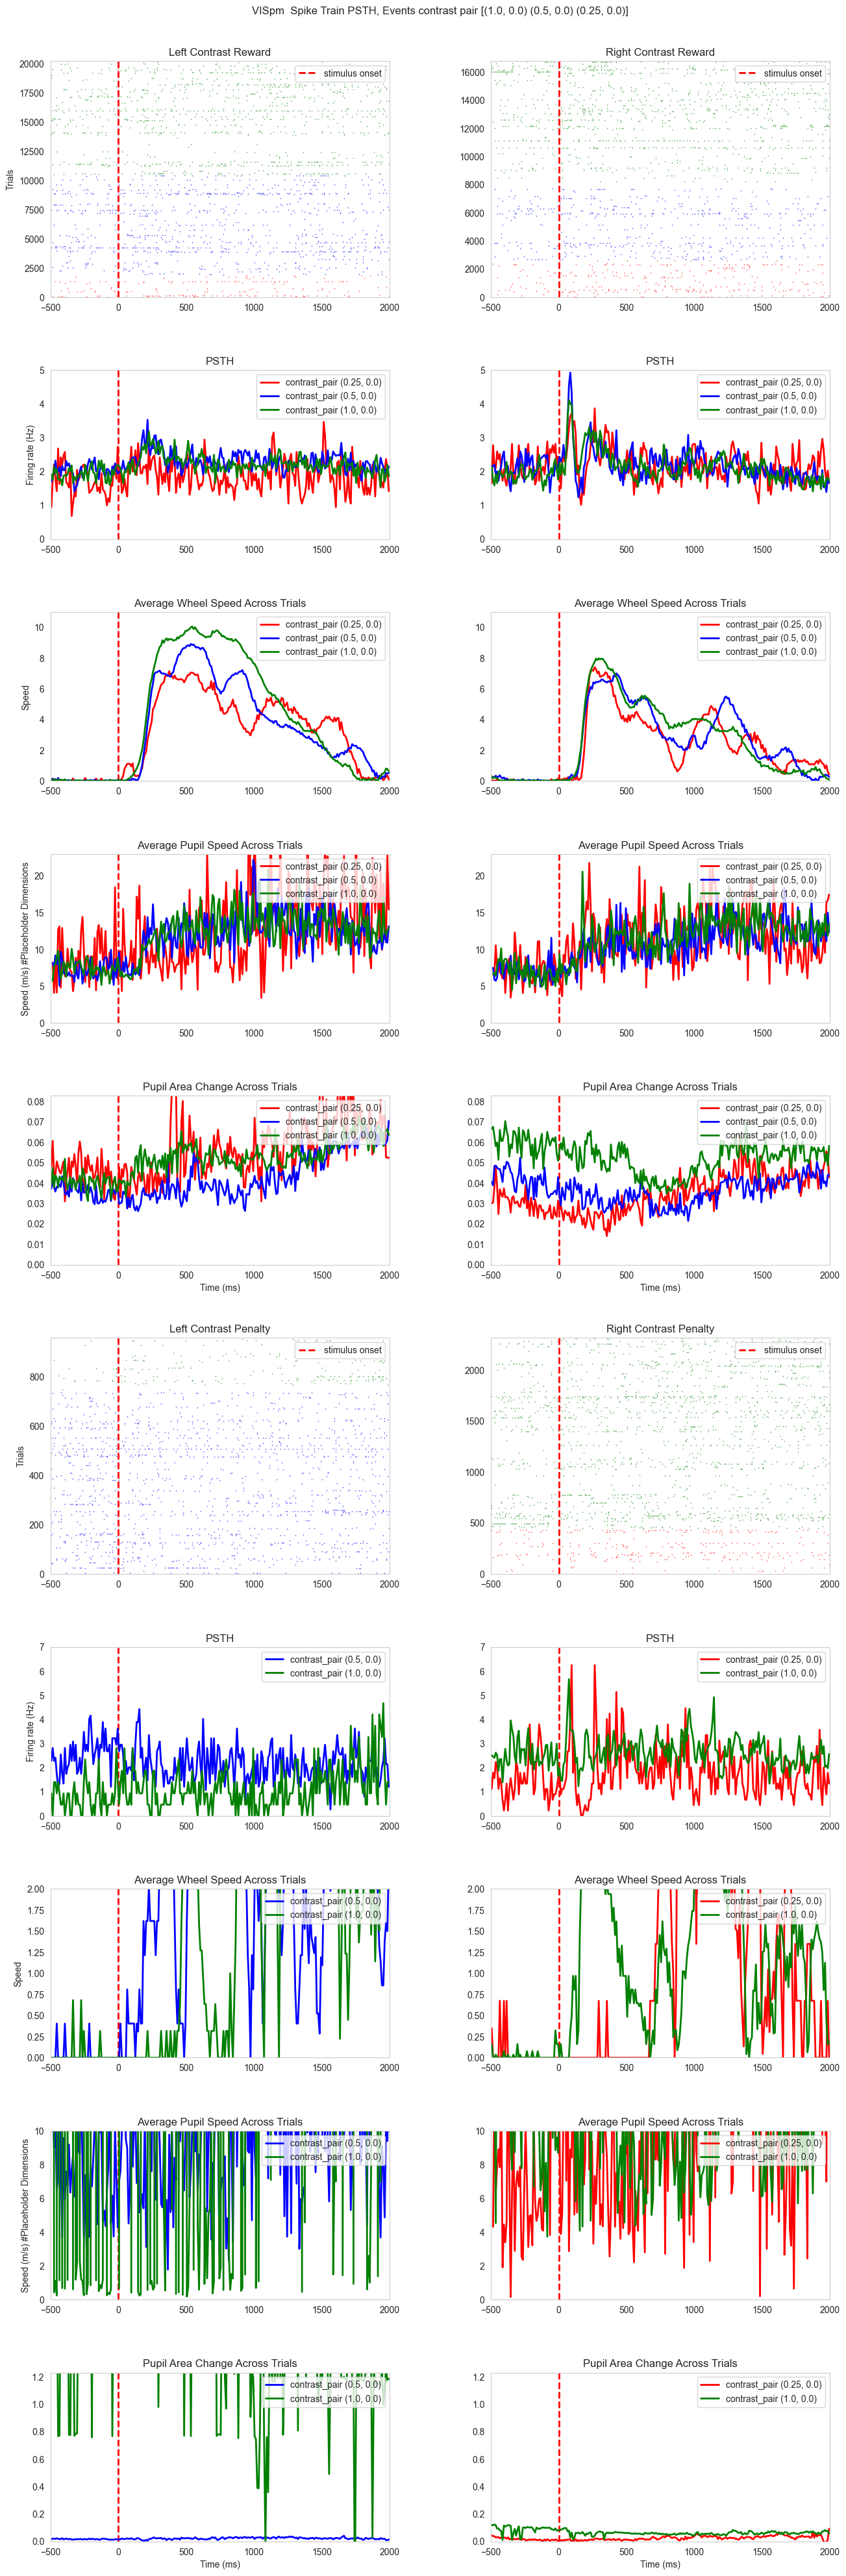

In [29]:
fig2 = plot_decision_trials_eventplot(no_stim_df,area='VISpm', color_dict= combination_to_color)

In [30]:
# plt.ioff()  # Add this at the start of your code
# for region, subregions in brain_groups.items():
#     save_path = os.path.join(root,"figures",region)
#     print(save_path)
#     for subregion in subregions:
#         save_file = os.path.join(save_path,f'{subregion}')
#         if (os.path.isfile(save_file+"_stim_png")) and (os.path.isfile(save_file+"_nostim.png")):
#             print("pass")
#             continue
#         else:
#             print('processing')
#             try:
#                 stim_fig = plot_decision_trials_eventplot(data_df=stimulus_df,area=subregion,color_dict=combination_to_color)
#                 stim_fig.savefig(save_file+"_stim.png", dpi=300, bbox_inches='tight')
#                 no_stim_fig = plot_decision_trials_eventplot(data_df=no_stim_df,area=subregion,color_dict=combination_to_color)
#                 no_stim_fig.savefig(save_file+"_nostim.png", dpi=300, bbox_inches='tight')
#             except:
#                 continue
# plt.ion()


In [31]:
new_df = concat_df.groupby(['brain_area', 'trial_outcome', 'contrast_pair'])['spks'].agg(lambda x: np.mean(np.stack(x), axis=0)*100)

In [32]:
# test_psth = new_df.loc[(new_df.index.get_level_values('brain_area')=="SCs") & (new_df.index.get_level_values('trial_outcome')=="right_reward")].iloc[1]

In [33]:
def calculate_psth(x):
    return np.mean(np.stack(x), axis=0)*100

In [34]:
def smooth_psth(psth, method='gaussian', **kwargs):
    """
    Smooth a Peri-Stimulus Time Histogram using various methods.

    Parameters:
    -----------
    psth : numpy.ndarray
        The raw PSTH data
    method : str
        Smoothing method ('gaussian', 'moving_average', or 'savgol')
    kwargs : dict
        Additional parameters specific to each method

    Returns:
    --------
    numpy.ndarray
        Smoothed PSTH data
    """

    if method == 'gaussian':
        # Gaussian smoothing
        sigma = kwargs.get('sigma', 2)
        return gaussian_filter(psth, sigma=sigma)

    elif method == 'moving_average':
        # Moving average smoothing
        window_size = kwargs.get('window_size', 5)
        kernel = np.ones(window_size) / window_size
        return np.convolve(psth, kernel, mode='same')

    elif method == 'savgol':
        # Savitzky-Golay filtering
        window_length = kwargs.get('window_length', 5)
        poly_order = kwargs.get('poly_order', 2)
        return savgol_filter(psth, window_length, poly_order)

    else:
        raise ValueError("Unknown smoothing method")

In [35]:
def find_closest_number(arr, num1, num2):
    """
    Find the closest number in array between two specified numbers.

    Parameters:
    arr (array-like): Input array of numbers
    num1 (float/int): First boundary number
    num2 (float/int): Second boundary number

    Returns:
    number: Closest value in array between num1 and num2
    index: Index of the closest value
    """
    # Convert to numpy array if not already
    arr = np.array(arr)

    # Determine min and max bounds
    lower_bound = min(num1, num2)
    upper_bound = max(num1, num2)

    # Find values within the range
    mask = (arr >= lower_bound) & (arr <= upper_bound)
    values_in_range = arr[mask]

    if len(values_in_range) == 0:
        # If no values in range, find closest to either boundary
        dist_to_lower = np.abs(arr - lower_bound)
        dist_to_upper = np.abs(arr - upper_bound)
        min_dist = np.minimum(dist_to_lower, dist_to_upper)
        closest_idx = np.argmin(min_dist)
        return arr[closest_idx], closest_idx
    else:
        # If values exist in range, return one of them
        closest_idx = mask.nonzero()[0][0]
        return values_in_range[0], closest_idx

In [79]:
def latency_response_detection(x):

    psth = calculate_psth(x)

    baseline = x[:,:50]

    gaussian_psth = smooth_psth(psth, 'gaussian', sigma=2)

    baseline_mean = np.mean(np.sum(baseline,axis=1)/500)
    std = np.std(np.sum(baseline,axis=1)/500)
    baseline_threshold = baseline_mean + 2*std

    # Use gaussian for peak locations
    # Use raw for baseline and threshold calculations
    # Find start of threshold post-stimulus and

    # Find where signal crosses threshold between consecutive points
    sign_diff = np.diff(np.sign(gaussian_psth - baseline_mean))
    # Get indices where crossings occur
    # sign_diff will be:
    #  2 for crossing from below to above (decay)
    # -2 for crossing from above to below (rise)
    crossing_indices = np.where(sign_diff == 2)[0] #look for rise only

    peaks, properties = find_peaks(gaussian_psth,height= baseline_threshold,distance=int(100/10))


    if (peaks[peaks>50].size > 0) and (crossing_indices[crossing_indices>50].size > 0):
        first_rise = crossing_indices[np.where(np.abs(crossing_indices-50)==np.min(np.abs(crossing_indices-50)))[0]]
        peaks_after_50 = peaks[peaks>50]
        first_peak = peaks_after_50[peaks_after_50>first_rise][0]
        print("first_peak:",first_peak)
        print("first_rise:",first_rise)
        half_height = baseline_mean + ((psth[first_peak] - psth[first_rise])/2)
        print("half_height:",half_height)
        lat_sign_diff = np.diff(np.sign(gaussian_psth - half_height))
        lat_cross = np.where(lat_sign_diff == 2)[0]
        print("lat_cross_first_rise:",lat_cross > first_rise)
        print("lat_cross_first_peak:",lat_cross < first_peak)
        lat_cross_mask = np.logical_and(lat_cross > first_rise, lat_cross < first_peak)
        print("lat_cross_mask:",lat_cross_mask)
        print("lat_cross_mask_bool:",np.all(~lat_cross_mask))
        if np.all(~lat_cross_mask):
            lat_cross = 0
            peak_firing_rate =0
        else:
            lat_cross = lat_cross[lat_cross_mask][0]
            peak_firing_rate = (psth[first_peak]-baseline_mean)/std
    else:
        lat_cross = 0
        peak_firing_rate = 0
    print("lat_cross_firing_rate:",lat_cross)
    print("peak_firing_rate:",peak_firing_rate)
    return lat_cross, peak_firing_rate

In [37]:
def calculate_response_latency(psth_values, baseline_period=50, significance_level=0.05, min_consecutive=3):
    """
    Calculate response latency from PSTH data using statistical threshold crossing.

    Parameters:
    -----------
    psth_values : array-like
        PSTH values across 250 time bins
    baseline_period : int
        Number of bins to use for baseline calculation (default: 50)
    significance_level : float
        Statistical significance level for threshold (default: 0.05)
    min_consecutive : int
        Minimum number of consecutive bins above threshold (default: 3)

    Returns:
    --------
    latency : int
        Bin number where response starts
    threshold : float
        Calculated threshold value
    """
    # Convert input to numpy array
    psth = np.array(psth_values)

    # Calculate baseline statistics
    baseline = psth[:baseline_period]
    post_baseline = np.median(psth[baseline_period:])
    baseline_mean = np.median(baseline)
    baseline_std = np.std(baseline)
    # Calculate threshold using mean + Z-score * std
    z_score = stats.norm.ppf(1 - significance_level)
    threshold = baseline_mean + z_score * baseline_std

    # Find bins above threshold
    above_threshold = psth > threshold

    # Look for consecutive bins above threshold
    latency = None
    consecutive_count = 0

    for bin_num in range(baseline_period, len(psth)):
        if above_threshold[bin_num]:
            consecutive_count += 1
            if consecutive_count >= min_consecutive:
                latency = bin_num - min_consecutive + 1
                break
        else:
            consecutive_count = 0

    if latency is None:
        return 0

    return latency-baseline_period

In [38]:
visp_df = concat_df.query('brain_area == "VISp"')

In [80]:
exp_df = concat_df.groupby(['brain_area', 'trial_outcome', 'contrast_pair']).agg({
    'spks': [
        ('psth', lambda x: calculate_psth(np.stack(x))*10),
        ('latency_response', lambda x: latency_response_detection(np.stack(x))[0]),
        ('peak_firing_rate', lambda x: latency_response_detection(np.stack(x))[1]),
    ]
}).reset_index()


Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:
lat_cross: 0
peak_firing_rate: 0
Final values:

In [62]:
exp_df.head(500)

brain_area  trial_outcome contrast_pair  \
                                              
0          ACA   left_penalty   (0.25, 0.0)   
1          ACA   left_penalty    (0.5, 0.0)   
2          ACA   left_penalty   (0.5, 0.25)   
3          ACA   left_penalty    (1.0, 0.0)   
4          ACA   left_penalty   (1.0, 0.25)   
..         ...            ...           ...   
495        EPd  right_penalty   (0.5, 0.25)   
496        EPd  right_penalty    (1.0, 0.5)   
497        EPd   right_reward   (0.25, 0.0)   
498        EPd   right_reward    (0.5, 0.0)   
499        EPd   right_reward   (0.5, 0.25)   

                                                  spks                   \
                                                  psth latency_response   
0    [23.529411764705884, 5.882352941176471, 11.764...                0   
1    [19.801980198019802, 9.900990099009901, 9.9009...                0   
2    [5.3908355795148255, 12.578616352201259, 9.883...                0   
3    [14.778325123152708, 14.778325123152708, 9.852...                0   
4    [10.501750291715286, 16.33605600933489, 18.669...                0   
..                                                 ...              ...   
495  [4.8076923076923075, 0.0, 14.423076923076923, ...                0   
496  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...                0   
497  [16.826923076923077, 2.4038461538461537, 0.0, ...                0   
498  [6.41025641025641, 6.41025641025641, 3.2051282...                0   
499  [5.76923076923077, 3.8461538461538463, 3.84615...                0   

                      
    peak_firing_rate  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
..               ...  
495              0.0  
496              0.0  
497              0.0  
498              0.0  
499              0.0  

[500 rows x 6 columns]

In [41]:
exp_df.columns

MultiIndex([(   'brain_area',                 ''),
            ('trial_outcome',                 ''),
            ('contrast_pair',                 ''),
            (         'spks',             'psth'),
            (         'spks', 'latency_response'),
            (         'spks', 'peak_firing_rate')],
           )

In [64]:
contralat_1_0_df = exp_df
if isinstance(contralat_1_0_df.columns, pd.MultiIndex):
    contralat_1_0_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in contralat_1_0_df.columns]
contralat_1_0_df = contralat_1_0_df[(contralat_1_0_df['contrast_pair']==(1.0,0.25)) & (contralat_1_0_df['trial_outcome']=="right_reward") ]
contralat_1_0_df.head(500)

,brain_area,trial_outcome,contrast_pair,spks_psth,spks_latency_response,spks_peak_firing_rate
32,ACA,right_reward,"(1.0, 0.25)","[11.4520891115684, 12.078375234857294, 12.5257...",0,0.0
64,ACB,right_reward,"(1.0, 0.25)","[12.802768166089965, 14.705882352941176, 14.53...",0,0.0
95,APN,right_reward,"(1.0, 0.25)","[108.0939947780679, 103.91644908616188, 99.216...",0,0.0
126,AUD,right_reward,"(1.0, 0.25)","[8.869179600886918, 5.912786400591279, 5.17368...",0,0.0
156,BLA,right_reward,"(1.0, 0.25)","[16.384489350081925, 14.381940651738576, 16.02...",0,0.0
...,...,...,...,...,...,...
2107,VISrl,right_reward,"(1.0, 0.25)","[4.559270516717325, 3.546099290780142, 2.53292...",0,0.0
2137,VPL,right_reward,"(1.0, 0.25)","[52.59165613147914, 57.142857142857146, 55.625...",0,0.0
2168,VPM,right_reward,"(1.0, 0.25)","[28.683181225554108, 34.91235694625525, 33.753...",0,0.0
2198,ZI,right_reward,"(1.0, 0.25)","[47.64150943396227, 46.38364779874213, 41.0377...",0,0.0


In [89]:
# new_df = visp_df.groupby(['brain_area','neuron_id', 'trial_outcome', 'contrast_pair']).agg({
#     'spks': [
#         ('psth', lambda x: calculate_psth(np.stack(x))*10),
#         ('latency_response', lambda x: (latency_response_detection(np.stack(x))[0]-50)*10),
#         ('peak_firing_rate', lambda x: latency_response_detection(np.stack(x))[1]),
#     ]
# })

first_peak: 58
first_rise: [50]
half_height: [16.67066667]
first_peak: 126
first_rise: [11]
half_height: [25.001]
first_peak: 51
first_rise: [26]
half_height: [50.002]
first_peak: 72
first_rise: [38]
half_height: [12.502]
first_peak: 89
first_rise: [74]
half_height: [0.00145455]
first_peak: 98
first_rise: [88]
half_height: [0.0048]
first_peak: 58
first_rise: [49]
half_height: [8.33533333]
first_peak: 98
first_rise: [89]
half_height: [12.501]
first_peak: 78
first_rise: [61]
half_height: [0.005]
first_peak: 134
first_rise: [10]
half_height: [50.002]
first_peak: 70
first_rise: [62]
half_height: [3.334]
first_peak: 78
first_rise: [67]
half_height: [2.382]
first_peak: 83
first_rise: [73]
half_height: [3.334]
first_peak: 56
first_rise: [48]
half_height: [4.54654545]
first_peak: 118
first_rise: [110]
half_height: [4.547]
first_peak: 53
first_rise: [37]
half_height: [1.38922222]
first_peak: 73
first_rise: [64]
half_height: [8.33533333]
first_peak: 108
first_rise: [99]
half_height: [0.00188235]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
new_df.head(500)

spks  \
                                                                                               psth   
brain_area neuron_id trial_outcome contrast_pair                                                      
VISp       0         left_penalty  (0.25, 0.0)    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                                   (0.5, 0.0)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                                   (0.5, 0.25)    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                                   (1.0, 0.0)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                                   (1.0, 0.25)    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                                                             ...   
           15        left_reward   (0.5, 0.25)    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                                   (1.0, 0.0)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 21.7391304...   
                                   (1.0, 0.25)    [0.0, 43.47826086956522, 0.0, 0.0, 43.47826086...   
                                   (1.0, 0.5)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
                     nogo          (0.0, 0.0)     [0.0, 14.925373134328357, 4.975124378109453, 4...   

                                                                   \
                                                 latency_response   
brain_area neuron_id trial_outcome contrast_pair                    
VISp       0         left_penalty  (0.25, 0.0)                116   
                                   (0.5, 0.0)                   0   
                                   (0.5, 0.25)                  0   
                                   (1.0, 0.0)                  46   
                                   (1.0, 0.25)                  5   
...                                                           ...   
           15        left_reward   (0.5, 0.25)                  0   
                                   (1.0, 0.0)                   0   
                                   (1.0, 0.25)                  0   
                                   (1.0, 0.5)                   0   
                     nogo          (0.0, 0.0)                  83   

                                                                   
                                                 peak_firing_rate  
brain_area neuron_id trial_outcome contrast_pair                   
VISp       0         left_penalty  (0.25, 0.0)           0.000000  
                                   (0.5, 0.0)            0.000000  
                                   (0.5, 0.25)           0.000000  
                                   (1.0, 0.0)            0.000000  
                                   (1.0, 0.25)           0.000000  
...                                                           ...  
           15        left_reward   (0.5, 0.25)           0.000000  
                                   (1.0, 0.0)            0.000000  
                                   (1.0, 0.25)          43.478261  
                                   (1.0, 0.5)            0.000000  
                     nogo          (0.0, 0.0)            0.000000  

[500 rows x 3 columns]

In [44]:
exp_df.head(500)

spks  \
                                                                                     psth   
brain_area trial_outcome contrast_pair                                                      
ACA        left_penalty  (0.25, 0.0)    [23.529411764705884, 5.882352941176471, 11.764...   
                         (0.5, 0.0)     [19.801980198019802, 9.900990099009901, 9.9009...   
                         (0.5, 0.25)    [5.3908355795148255, 12.578616352201259, 9.883...   
                         (1.0, 0.0)     [14.778325123152708, 14.778325123152708, 9.852...   
                         (1.0, 0.25)    [10.501750291715286, 16.33605600933489, 18.669...   
...                                                                                   ...   
EPd        right_penalty (0.5, 0.25)    [4.8076923076923075, 0.0, 14.423076923076923, ...   
                         (1.0, 0.5)     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           right_reward  (0.25, 0.0)    [16.826923076923077, 2.4038461538461537, 0.0, ...   
                         (0.5, 0.0)     [6.41025641025641, 6.41025641025641, 3.2051282...   
                         (0.5, 0.25)    [5.76923076923077, 3.8461538461538463, 3.84615...   

                                                                              
                                       latency_response     peak_firing_rate  
brain_area trial_outcome contrast_pair                                        
ACA        left_penalty  (0.25, 0.0)               -500                    0  
                         (0.5, 0.0)                -500                    0  
                         (0.5, 0.25)               -500                    0  
                         (1.0, 0.0)                -500                    0  
                         (1.0, 0.25)               -500                    0  
...                                                 ...                  ...  
EPd        right_penalty (0.5, 0.25)               -500                    0  
                         (1.0, 0.5)                 410  [973.1236802019038]  
           right_reward  (0.25, 0.0)               -500                    0  
                         (0.5, 0.0)                -500                    0  
                         (0.5, 0.25)               -500                    0  

[500 rows x 3 columns]

In [45]:
latency_df = exp_df.reset_index()
latency_df.head()

brain_area trial_outcome contrast_pair  \
                                           
0        ACA  left_penalty   (0.25, 0.0)   
1        ACA  left_penalty    (0.5, 0.0)   
2        ACA  left_penalty   (0.5, 0.25)   
3        ACA  left_penalty    (1.0, 0.0)   
4        ACA  left_penalty   (1.0, 0.25)   

                                                spks                   \
                                                psth latency_response   
0  [23.529411764705884, 5.882352941176471, 11.764...             -500   
1  [19.801980198019802, 9.900990099009901, 9.9009...             -500   
2  [5.3908355795148255, 12.578616352201259, 9.883...             -500   
3  [14.778325123152708, 14.778325123152708, 9.852...             -500   
4  [10.501750291715286, 16.33605600933489, 18.669...             -500   

                    
  peak_firing_rate  
0                0  
1                0  
2                0  
3                0  
4                0

In [46]:
# test_df = latency_df[latency_df['trial_outcome'] == "right_reward"]
test_df = latency_df
if isinstance(test_df.columns, pd.MultiIndex):
    test_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in test_df.columns]

In [47]:
test_df.head(500)

,brain_area,trial_outcome,contrast_pair,spks_psth,spks_latency_response,spks_peak_firing_rate
0,ACA,left_penalty,"(0.25, 0.0)","[23.529411764705884, 5.882352941176471, 11.764...",-500,0
1,ACA,left_penalty,"(0.5, 0.0)","[19.801980198019802, 9.900990099009901, 9.9009...",-500,0
2,ACA,left_penalty,"(0.5, 0.25)","[5.3908355795148255, 12.578616352201259, 9.883...",-500,0
3,ACA,left_penalty,"(1.0, 0.0)","[14.778325123152708, 14.778325123152708, 9.852...",-500,0
4,ACA,left_penalty,"(1.0, 0.25)","[10.501750291715286, 16.33605600933489, 18.669...",-500,0
...,...,...,...,...,...,...
495,EPd,right_penalty,"(0.5, 0.25)","[4.8076923076923075, 0.0, 14.423076923076923, ...",-500,0
496,EPd,right_penalty,"(1.0, 0.5)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",410,[973.1236802019038]
497,EPd,right_reward,"(0.25, 0.0)","[16.826923076923077, 2.4038461538461537, 0.0, ...",-500,0
498,EPd,right_reward,"(0.5, 0.0)","[6.41025641025641, 6.41025641025641, 3.2051282...",-500,0


In [48]:
test_df[(test_df['contrast_pair']==(1.0,0.0)) & (test_df['trial_outcome'] == "right_reward")]

,brain_area,trial_outcome,contrast_pair,spks_psth,spks_latency_response,spks_peak_firing_rate
31,ACA,right_reward,"(1.0, 0.0)","[12.69001982815598, 13.615333773959023, 14.937...",-500,0
63,ACB,right_reward,"(1.0, 0.0)","[17.08519665176012, 17.08519665176012, 18.8051...",-500,0
94,APN,right_reward,"(1.0, 0.0)","[115.0413223140496, 117.68595041322314, 101.81...",-500,0
125,AUD,right_reward,"(1.0, 0.0)","[7.113821138211382, 10.670731707317074, 8.3841...",-500,0
155,BLA,right_reward,"(1.0, 0.0)","[15.307766677408958, 13.696422816629068, 13.69...",-500,0
...,...,...,...,...,...,...
2106,VISrl,right_reward,"(1.0, 0.0)","[6.3056379821958455, 5.007418397626113, 5.1928...",-500,0
2136,VPL,right_reward,"(1.0, 0.0)","[65.1748859439496, 59.526395828807296, 61.6988...",-500,0
2167,VPM,right_reward,"(1.0, 0.0)","[29.924135993256535, 30.767069401517276, 28.94...",-500,0
2197,ZI,right_reward,"(1.0, 0.0)","[47.73156899810964, 47.41650913673598, 48.8342...",-500,0


In [49]:
# test_psth = test_df[(test_df['contrast_pair']==(0.25,0.0)) & (test_df['trial_outcome']=='left_penalty')].iloc[:]
test_psth = np.array(test_df[(test_df['contrast_pair']==(1.0,0.0)) & (test_df['trial_outcome'] == "right_reward")]['spks_psth'].iloc[14])

In [50]:
test_psth.shape

(250,)

In [40]:
def generate_random_array(rows, cols=250, min_val=0, max_val=100):
    """
    Generate a random integer array of specified dimensions.

    Parameters:
    rows (int): Number of rows in the array
    cols (int): Number of columns (default 250)
    min_val (int): Minimum value for random integers (default 0)
    max_val (int): Maximum value for random integers (default 100)

    Returns:
    numpy.ndarray: Array of random integers
    """
    return np.random.randint(min_val, max_val, size=(rows, cols))

# Example usage:
# For a 5x250 array:
random_array = generate_random_array(5)

In [44]:
random_array.shape

(5, 250)

In [42]:
def latency_response_detection(psth):
    gaussian_psth = smooth_psth(psth, 'gaussian', sigma=2)

    baseline_mean = np.mean(psth[:50])
    baseline_threshold = baseline_mean + 2*np.std(psth[:50])

    # Use gaussian for peak locations
    # Use raw for baseline and threshold calculations
    # Find start of threshold post-stimulus and

    # Find where signal crosses threshold between consecutive points
    sign_diff = np.diff(np.sign(gaussian_psth - baseline_mean))
    # Get indices where crossings occur
    # sign_diff will be:
    #  2 for crossing from below to above (decay)
    # -2 for crossing from above to below (rise)
    crossing_indices = np.where(sign_diff == 2)[0] #look for rise only
    print(crossing_indices)

    peaks, properties = find_peaks(gaussian_psth,height= baseline_threshold,distance=int(100/10))
    print(peaks)

    if (peaks.size > 0) and (crossing_indices.size > 0):
        first_peak = peaks[np.where(np.abs(peaks-50)==np.min(np.abs(peaks-50)))[0]]
        print(first_peak)
        first_rise = crossing_indices[np.where(np.abs(crossing_indices-50)==np.min(np.abs(crossing_indices-50)))[0]]
        print(first_rise)
        half_height = baseline_mean + ((gaussian_psth[first_peak] - baseline_mean)/2)
        print(gaussian_psth[first_peak], psth[first_rise], half_height)

        lat_sign_diff = np.diff(np.sign(gaussian_psth - half_height))
        lat_cross = np.where(lat_sign_diff == 2)[0]
        print(lat_cross)
        lat_cross = lat_cross[np.where(np.abs(lat_cross-50)==np.min(np.abs(lat_cross-50)))[0]][0]
        print(lat_cross)
    else:
        lat_cross = 0
        half_height = baseline_mean+(baseline_threshold - baseline_mean)/2
        first_peak = 0
        first_rise = 0

    return gaussian_psth, baseline_mean , baseline_threshold, crossing_indices, peaks, half_height, lat_cross, first_peak, first_rise
    # return gaussian_psth, baseline_mean , baseline_threshold

In [62]:
lat, fr =latency_response_detection(random_array)
print(lat)

baseline: (5, 50)
gaussian_psth: (250,)
baseline_mean: 5.2148
std: 0.41650853532670856
baseline_threshold: 6.047817070653418
0


In [53]:
# g,bm,bt =latency_response_detection(test_psth)

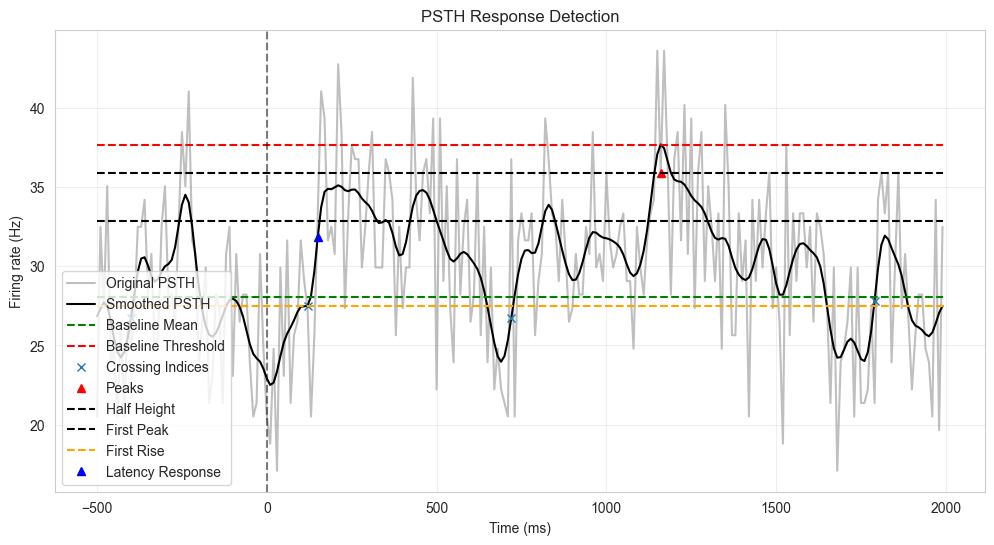

In [54]:
time_bins = np.arange(-500  , 2000, 10)
plt.figure(figsize=(12, 6))
plt.plot(time_bins, test_psth, 'gray', alpha=0.5, label='Original PSTH')
plt.plot(time_bins, g, 'k', label='Smoothed PSTH')
plt.plot(time_bins, bm*np.ones(time_bins.shape), 'g--', label='Baseline Mean')
plt.plot(time_bins, bt*np.ones(time_bins.shape), 'r--', label='Baseline Threshold')
plt.plot(time_bins[ci], g[ci], 'x', label='Crossing Indices')
plt.plot(time_bins[pks], test_psth[pks], 'r^', label='Peaks')
plt.plot(time_bins, half*np.ones(time_bins.shape), 'k--', label='Half Height')
plt.plot(time_bins, test_psth[fp]*np.ones(time_bins.shape), 'k--', label='First Peak')
plt.plot(time_bins, g[fr]*np.ones(time_bins.shape), color='orange',linestyle ='dashed', label='First Rise')
# plt.plot(time_bins, rmt,'orange', label='Rolling Median Threshold')
plt.plot(time_bins[lat],g[lat], 'b^', label='Latency Response')


# # Highlight detected response periods
# response_times = time_bins[results['response_bins']]
# response_values = results['smoothed_psth'][results['response_bins']]
# plt.plot(response_times, response_values, 'r', linewidth=2, label='Detected response')

plt.axvline(x=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel('Firing rate (Hz)')
plt.legend()
plt.title('PSTH Response Detection')
plt.grid(True, alpha=0.3)

plt.show()